# Titanic survivors
by Remi Ang (remi.r.ang@gmail.com)

<h1>1/ Initialization : </h1>
import pandas, os packages, define input datasets directory and files, rebuild paths

In [1]:
import pandas as pd
import os

# data files
train_file = 'Titanic_train.csv'
test_file = 'Titanic_test.csv'

<h1>2. Load the TRAIN dataset</h1> index 1st column (passenger ID) and display 10 first lines

In [4]:
# load training dataset

train = pd.read_csv(train_file)
# Index the dataframe with the passenger ID, yield a new object and remove the passenger ID column
train.set_index('PassengerId', inplace=True, drop=True)

<h1>3. Explore the TRAIN dataset</h1>
display first 10 rows, show types and count

In [5]:
print('The training dataset contains {} samples and {} features'.format(train.shape[0],train.shape[1]))

The training dataset contains 891 samples and 11 features


In [6]:
train.head(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S


In [7]:
train.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [8]:
train.dtypes

Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

In [9]:
train.count(axis=0)

Survived    891
Pclass      891
Name        891
Sex         891
Age         714
SibSp       891
Parch       891
Ticket      891
Fare        891
Cabin       204
Embarked    889
dtype: int64

* `Cabin` column is very incomplete, will need some wrangling
* `SibSp`, `Parch` and `Fare` are continue and complete

<h1> 4. Prediction value parsing</h1>

In [10]:
def parse_model_0(X):
    target = X.Survived
    X = X[['Fare','SibSp','Parch']]
    return (X, target)

X, y = parse_model_0(train.copy())

<h1>5. Logistic regression score cross validation</h1>
Average of 5 cross-validations

In [12]:
from sklearn.model_selection import cross_val_score
from statistics import mean
def compute_score(clf, X, y):
    xval = cross_val_score(clf, X, y, cv = 5)
    return mean(xval)

In [13]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
compute_score(lr, X, y)

0.674548857768335

<h1>6. Variables studies</h1>

In [14]:
# split the dataset in 2 populations : dead and survived
survived = train[train.Survived == 1]
dead = train[train.Survived == 0]

print('survivors : %d | dead : %s'%(survived.shape[0],dead.shape[0]))

survivors : 342 | dead : 549


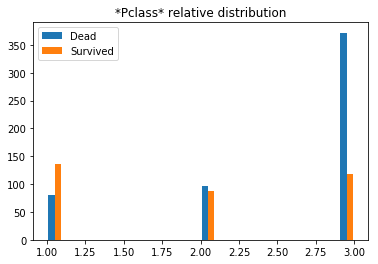

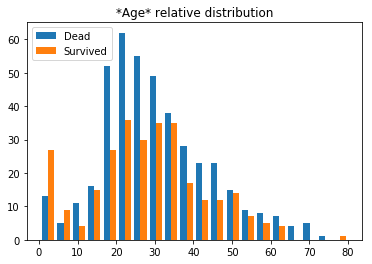

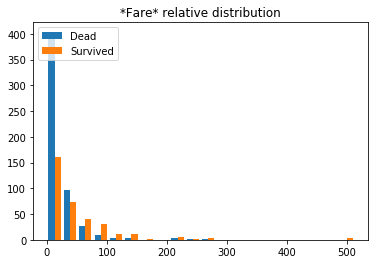

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
from numpy import array, ones_like
def plot_hist(feature, bins = 20):
    x1 = array(dead[feature].dropna())
    x2 = array(survived[feature].dropna())
    
    plt.hist([x1,x2],label=['Dead','Survived'], bins = bins)
    plt.legend(loc = 'upper left')
    plt.title('*{}* relative distribution'.format(feature))
    plt.show()
    
plot_hist('Pclass')
plot_hist('Age')
plot_hist('Fare')      

<h1>7. Parse PClass</h1>

In [16]:
#help(pd.get_dummies)

def parse_model_1(X):
    target = X.Survived 
    class_dummies = pd.get_dummies(X['Pclass'], prefix='split_class')
    X = X.join(class_dummies)
    
    # remove useless columns
    to_del = ['Name','Age','Cabin','Embarked','Survived','Ticket','Pclass','Sex']
    for col in to_del : del X[col]
    return X, target

X, y = parse_model_1(train.copy())
compute_score(lr, X, y)

0.6926591973081655

see variable weights...

[[-0.150896    0.23357229  0.00669907  0.3730938   0.100852   -0.85258357]]


<Container object of 6 artists>

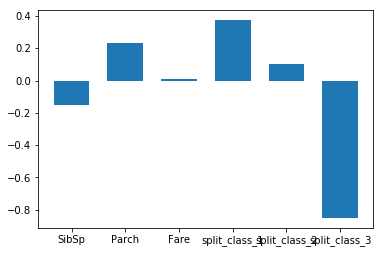

In [17]:
lr.fit(X, y)
print(lr.coef_)
plt.bar(range(len(X.columns)),lr.coef_[0],1/1.5,tick_label = X.columns)

<h1>8. Age and Sex</h1>

In [18]:
def parse_model_2(X):
    target = X.Survived
    
    # parse Pclass and Sex
    to_dummy = ['Pclass','Sex']
    for dum in to_dummy:
        split_temp = pd.get_dummies(X[dum], prefix = 'split_'+dum)
        for col in split_temp :
            X[col] = split_temp[col]
        del X[dum]
    
    #complete issing ages with median
    X['Age'] = X.Age.fillna(X.Age.median())
    
    # remove useless columns
    to_del = ['Name','Cabin','Embarked','Survived','Ticket']
    for col in to_del : del X[col]
    return X, target

X, y = parse_model_2(train.copy())
compute_score(lr, X, y)

0.7868160254657532

Age : Is it a child 

Score : 0.800274134181057
Coefficient weights : [[-0.02230835 -0.42181305 -0.19815929  0.004332    1.06824222  0.18410878
  -0.82525062  1.59541267 -1.1683123   1.72150169]]


<Container object of 10 artists>

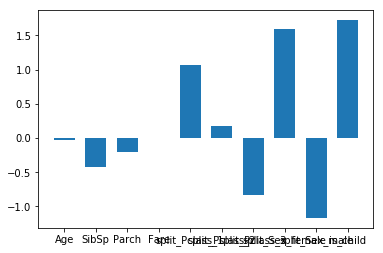

In [19]:
def parse_model_3(X):
    target = X.Survived
    
    # parse Pclass and Sex
    to_dummy = ['Pclass','Sex']
    for dum in to_dummy:
        split_temp = pd.get_dummies(X[dum], prefix = 'split_'+dum)
        for col in split_temp :
            X[col] = split_temp[col]
        del X[dum]
    
    #complete issing ages with median
    X['Age'] = X.Age.fillna(X.Age.median())
    X['is_child'] = X.Age < 8
    
    # remove useless columns
    to_del = ['Name','Cabin','Embarked','Survived','Ticket']
    for col in to_del : del X[col]
    return X, target

X, y = parse_model_3(train.copy())
score = compute_score(lr, X, y)
print('Score : {}'.format(score))
lr.fit(X, y)
print('Coefficient weights : {}'.format(lr.coef_))
plt.bar(range(len(X.columns)),lr.coef_[0],1/1.5,tick_label = X.columns)

<h1>9. Random Forest</h1>

In [20]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

X, y = parse_model_2(train.copy())
compute_score(rf, X, y)

0.8093006315725266

Estimation of relative importance of variables

Score : 0.8070154235053925


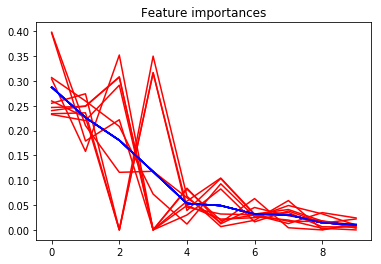

1. feature : Fare (0.287062)
2. feature : Age (0.226019)
3. feature : split_Sex_female (0.180399)
4. feature : split_Sex_male (0.117245)
5. feature : SibSp (0.053239)
6. feature : split_Pclass_3 (0.048954)
7. feature : Parch (0.031811)
8. feature : split_Pclass_1 (0.030539)
9. feature : is_child (0.014389)
10. feature : split_Pclass_2 (0.010342)


In [21]:
def clf_importance(X, clf):
    import pylab as pl
    import numpy as np
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]
    pl.title("Feature importances")
    for tree in clf.estimators_:
        pl.plot(range(X.shape[1]), tree.feature_importances_[indices],"r")
        pl.plot(range(X.shape[1]), importances[indices], "b")
    pl.show()
    for f in range(X.shape[1]):
        print("%d. feature : %s (%f)"% (f + 1, X.columns[indices[f]],importances[indices[f]]))

X, y = parse_model_3(train.copy())
score = compute_score(rf, X, y)
print('Score : {}'.format(score))
rf.fit(X, y)
clf_importance(X, rf)

<h1>10. Name and Cabin</h1>

In [22]:
def parse_model_4(X):
    target = X.Survived
    # extract title from the name
    X['Title'] = X.Name.map(lambda x: x.split(',')[1].split('.')[0])
    
    # extract if has or has not a surname from name
    X['Surname'] = X.Name.map(lambda x : '(' in x)
    
    # get cabin if any
    X['Cabin'] = X.Cabin.map(lambda x : x[0] if not pd.isnull(x) else -1)

    # parse Pclass, Sex and others
    to_dummy = ['Pclass','Sex','Title','Embarked','Cabin']
    for dum in to_dummy:
        split_feature = pd.get_dummies(X[dum], prefix = 'split_'+dum)
        X = X.join(split_feature)
        del X[dum]
 
    #complete issing ages with median
    X['Age'] = X.Age.fillna(X.Age.median())
    X['is_child'] = X.Age < 8
    
    # remove useless columns
    to_del = ['Name','Survived','Ticket']
    for col in to_del : del X[col]
        
    return X, target

X, y = parse_model_4(train.copy())

LogisticRegression Score : 0.8238448861562948
Coefficient weights : [[-0.02374722 -0.5206733  -0.3771428   0.00518699  0.98625459  0.72204108
   0.4292982  -0.51683176  1.12641865 -0.49191113 -0.19752618  0.14524331
  -0.37498567 -0.16341019 -0.27929748  0.07597255  0.05727005  1.79224423
   0.32912008  0.08023154  0.05121684 -0.84398325  0.27603417  0.22876079
  -0.82155693  0.24438969  0.03478395  0.33587864  0.28186724 -0.10112741
  -0.51300281  0.05303841  0.24316966 -0.11100334  0.76561121  0.96194421
   0.10375548 -0.63950677 -0.22949854  0.78440548]]


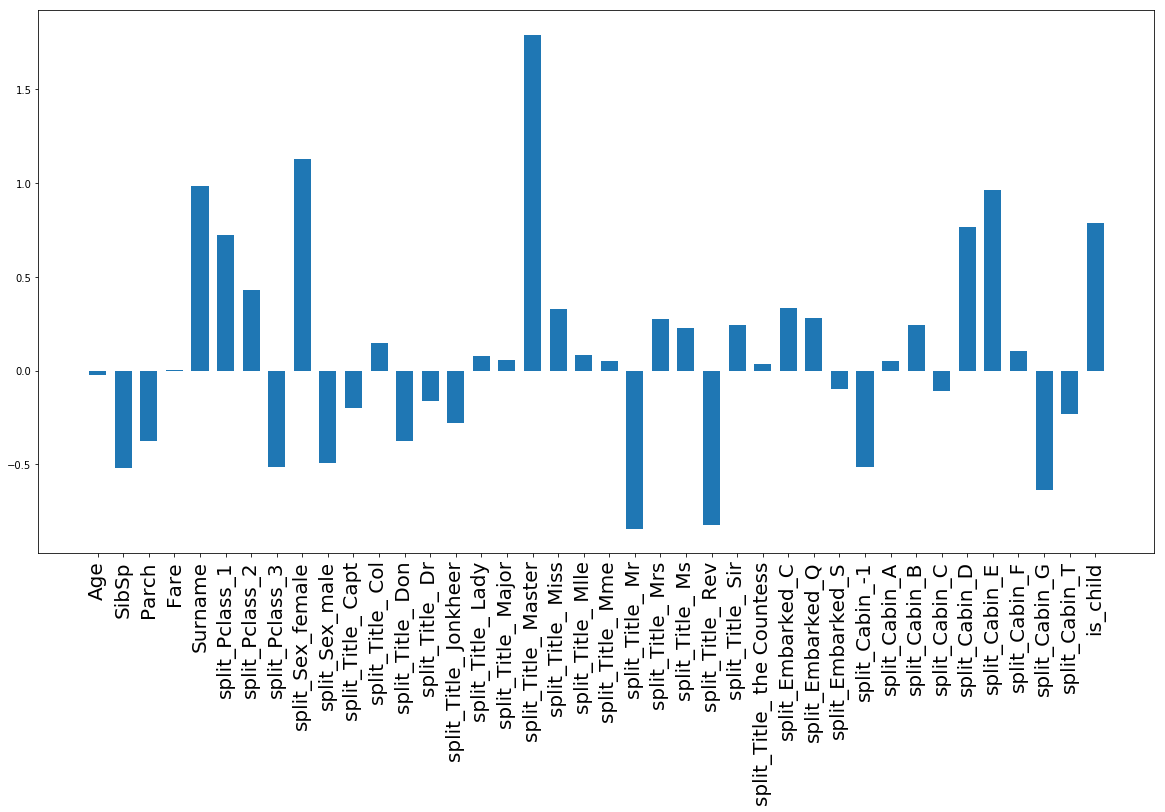

In [23]:
lr = LogisticRegression()
score = compute_score(lr, X, y)
print('LogisticRegression Score : {}'.format(score))
lr.fit(X, y)
print('Coefficient weights : {}'.format(lr.coef_))
plt.figure(figsize=(20,10))
plt.bar(range(len(X.columns)),lr.coef_[0],1/1.5,tick_label = X.columns)
plt.setp(plt.gca().get_xmajorticklabels(),size=20,rotation=90); 

RandomForest Score : 0.8058667906476624


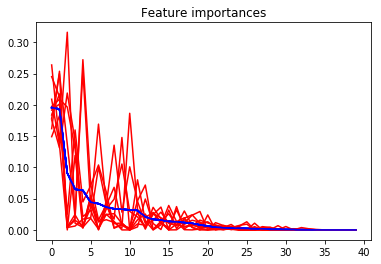

1. feature : Fare (0.195565)
2. feature : Age (0.193315)
3. feature : split_Sex_male (0.090918)
4. feature : Surname (0.064990)
5. feature : split_Title_ Mr (0.063196)
6. feature : SibSp (0.044225)
7. feature : split_Title_ Miss (0.042007)
8. feature : Parch (0.036466)
9. feature : split_Cabin_-1 (0.033768)
10. feature : split_Title_ Mrs (0.033113)
11. feature : split_Sex_female (0.031997)
12. feature : split_Pclass_3 (0.031201)
13. feature : split_Pclass_1 (0.020848)
14. feature : split_Pclass_2 (0.016930)
15. feature : split_Embarked_C (0.015962)
16. feature : split_Title_ Master (0.013613)
17. feature : split_Embarked_Q (0.012883)
18. feature : split_Embarked_S (0.011707)
19. feature : is_child (0.010439)
20. feature : split_Cabin_C (0.008097)
21. feature : split_Cabin_D (0.006140)
22. feature : split_Cabin_E (0.004317)
23. feature : split_Cabin_B (0.003364)
24. feature : split_Cabin_A (0.003192)
25. feature : split_Cabin_G (0.002489)
26. feature : split_Title_ Capt (0.002221)
27. f

In [24]:
score = compute_score(rf, X, y)
print('RandomForest Score : {}'.format(score))
rf.fit(X, y)
clf_importance(X, rf)  